# Pupilometria - Transformada de Hough

## Preparação dos Dados

Importando pasta pessoal do Google Drive contendo as imagens do dataset.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Importando as bibliotecas utilizadas neste experinddadto.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')

import numpy as np

from skimage import io
from skimage import img_as_float, img_as_ubyte

from skimage.color import rgb2gray, gray2rgb
from skimage.draw import circle
from skimage.morphology import square 

from skimage.filters import gaussian as gaussian_filter
from skimage.filters import sobel, sobel_v, sobel_h
from skimage.filters import scharr, scharr_v, scharr_h
from skimage.filters import prewitt, prewitt_v, prewitt_h
from skimage.filters.rank import mean as mean_filter, median as median_filter

from skimage.exposure import rescale_intensity, equalize_hist
from skimage.exposure import equalize_adapthist, cumulative_distribution

from skimage.draw import circle_perimeter
from skimage.measure import regionprops, label as measure_label

from skimage.filters import threshold_otsu
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Definindo funções para plotagem de imagens.

In [3]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows, ncols, figsize=(6, 6))
    ax.imshow(img_as_float(image), cmap='gray')
    return fig, ax

def image_show_all(*images, titles=None, cmap='gray'):
    images = [img_as_float(image) for image in images]

    if titles is None:
        titles = [''] * len(images)

    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 6
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap='gray')
        ax.set_title(label)

Carregando uma imagem de pupilometria de um paciente.

*   Paciente: 12
*   Coleta: 2

Type: <class 'numpy.ndarray'>
Data type: float64
Shape: (480, 640)
Min/Max: 0.10001921568627452 0.8843329411764705


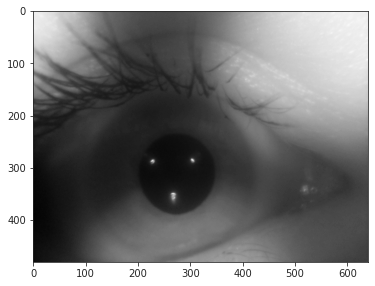

In [71]:
path = '/content/drive/My Drive/TCC/datasetpupilometro/DATASET/Teste/'

original = rgb2gray(io.imread(path + '48_1_frame_0149.jpg'))

print('Type:', type(original))
print('Data type:', original.dtype)
print('Shape:', original.shape)
print('Min/Max:', original.min(), original.max())

image_show(original);

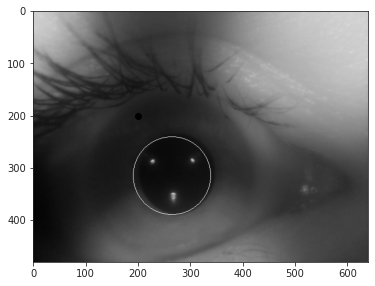

In [72]:
r_coords_pupil, c_coords_pupil = circle_perimeter(315, 265, 74, shape=original.shape)
original[r_coords_pupil, c_coords_pupil] = 1

fig, ax = image_show(original)
ax.plot(200, 200, 'ko');

## Pré-Processamento

Removendo ruído na imagem original e comparando alguns filtros.

In [ ]:
selem = square(width=7)
print('Elemento estruturante:\n', selem)

Elemento estruturante:
 [[1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]]


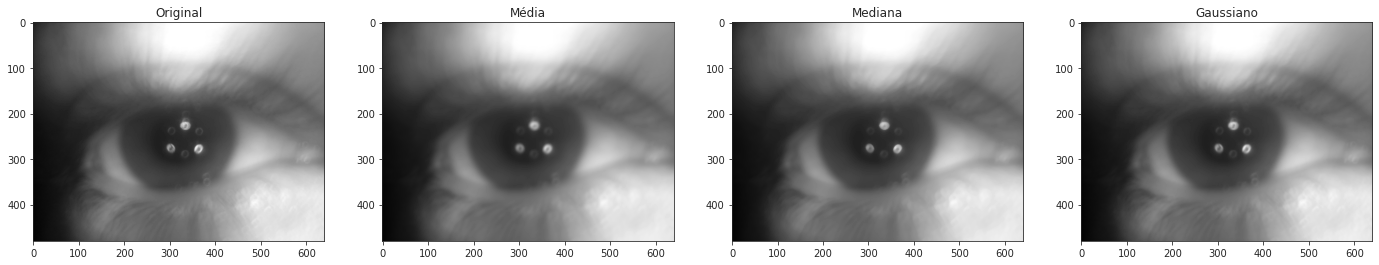

In [ ]:
mean = mean_filter(img_as_ubyte(original), selem)
median = median_filter(img_as_ubyte(original), selem)
gaussian = gaussian_filter(original, sigma=1)

image_show_all(original, mean, median, gaussian, 
               titles=['Original', 'Média', 'Mediana', 'Gaussiano']);

Experimentando filtros com base em histograma.

In [ ]:
def plot_img_and_hist(img, axes, bins=256):
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Mostra a imagem
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Mostra o histograma
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Intensidade')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Mostra a distribuição cumulativa
    img_cdf, bins = cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

In [ ]:
# Alongamento de constraste
p2, p98 = np.percentile(original, (2, 98))
contrast = rescale_intensity(original, in_range=(p2, p98))

# Equalização de histograma
eq_hist = equalize_hist(original)

# Equalização de histograma adaptativa
adapt_eq_hist = equalize_adapthist(original, clip_limit=0.03)

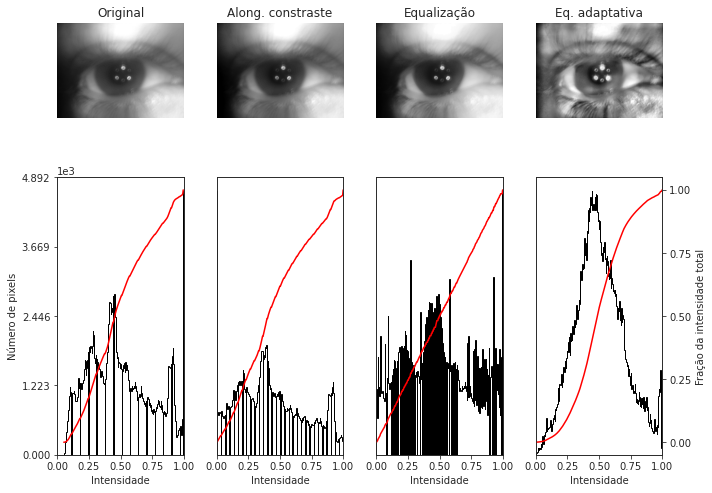

In [ ]:
# Mostrando os resultados
fig = plt.figure(figsize=(10, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0, 0], sharey=axes[0, 0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(original, axes[:, 0])
ax_img.set_title('Original')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Número de pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(contrast, axes[:, 1])
ax_img.set_title('Along. constraste')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(eq_hist, axes[:, 2])
ax_img.set_title('Equalização')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(adapt_eq_hist, axes[:, 3])
ax_img.set_title('Eq. adaptativa')

ax_cdf.set_ylabel('Fração da intensidade total')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# Sem overlap nos rótulos do eixo y
fig.tight_layout();

---

### Removendo Reflexos Especulares

O conjunto de LEDs infravermelhos usados para iluminação do olho durante a gravação dos vídeos gera reflexos especulares em sua superfície, que aparecem na imagem como pontos claros sobre a pupila.

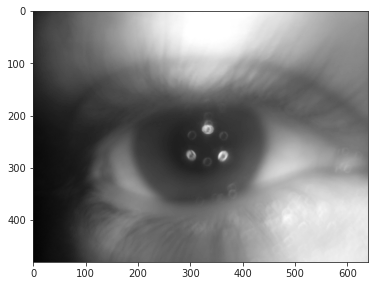

In [ ]:
image_show(original);

In [ ]:
def change_value_neighborhood(img, pixel, L):
  r, c = pixel[0], pixel[1]
  
  # Acha as coordenadas de um círculo de raio L centrado em (x, y)
  r_coords, c_coords = circle(r, c, L, img.shape)

  # Calcula o valor mínimo entre todos os pixel localizados a uma distância menor que L 
  new_value = img[r_coords, c_coords].min()

  # Substitui o pixel e seus vizinhos pelo novo valor
  img[r_coords, c_coords] = new_value
  return

def mean_value_neighborhood(img, pixel):
  r, c = pixel[0], pixel[1]
  return np.mean([img[r, c], img[r+1, c], img[r-1, c], img[r, c+1], img[r, c-1]])

def remove_flashes(img, L=6, k=1.5):
  print('Removendo reflexos especulares...')
  
  lim_min, lim_row_max, lim_col_max, = L+1, img.shape[0]-L-1, img.shape[1]-L-1

  # Para cada pixel (x, y)
  for r in range(lim_min, lim_row_max):
    for c in range(lim_min, lim_col_max):
      # Calcula o valor médio entre o pixel e sua 4-vizinhança
      v0 = mean_value_neighborhood(img, pixel=(r, c))
     
      # Calcula o valor médio dos pixels L distantes
      vr = mean_value_neighborhood(img, pixel=(r+L, c))
      vl = mean_value_neighborhood(img, pixel=(r-L, c))
      vu = mean_value_neighborhood(img, pixel=(r, c+L))
      vd = mean_value_neighborhood(img, pixel=(r, c-L))

      # Verifica se pixel está próximo ao centro do artefato a ser removido
      change_pixel = (v0 > vr*k) and (v0 > vl*k) and (vu > vr*k) and (vd > vr*k)
      if change_pixel:
        print('Artefato no pixel:', (r, c))
        change_value_neighborhood(img, (r, c), L)
  
  return img

O parâmetro **L** é ajustado de acordo com o raio dos artefatos que se deseja eliminar. Um valor muito alto pode levar a detecções incorretas e alterações indesejadas na imagem, enquanto um valor baixo poderia reduzir a eficácia do método ao ignorar um ou mais reflexos.

A relação **k** é obtida pela análise dos níveis de cinza dos artefatos e das regiões próximas nas imagens. Um valor baixo pode levar à identificação incorreta de artefatos, enquanto um valor elevado faz com que alguns reflexos sejam ignorados.

Removendo reflexos especulares...
Artefato no pixel: (227, 334)
Artefato no pixel: (233, 309)
Artefato no pixel: (285, 340)


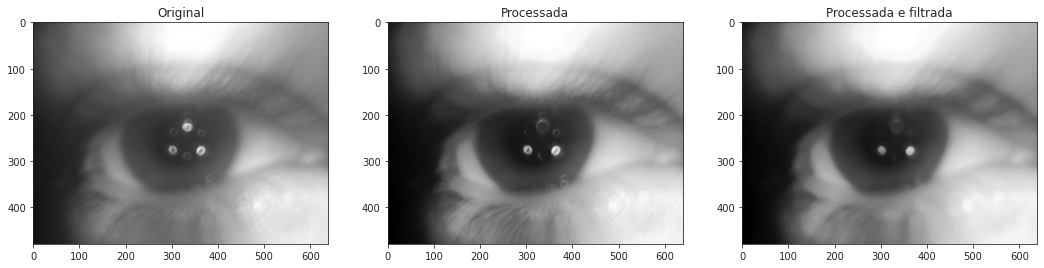

In [ ]:
flashes_removed = eq_hist.copy()

# L e k definidos empiricamente
L = 12
k = 1.3
remove_flashes(flashes_removed, L, k)
flashes_removed_final = median_filter(img_as_ubyte(flashes_removed), square(L))

image_show_all(original, flashes_removed, flashes_removed_final, 
               titles=['Original', 'Processada', 'Processada e filtrada']);

## Segmentação da Pupila

### Detecção de Bordas

Utilizando Canny para detecção de bordas na imagem.

**- Problema: especificação dos parâmetros do filtro de Canny**

*sigma, low_threshold e high_threshold*

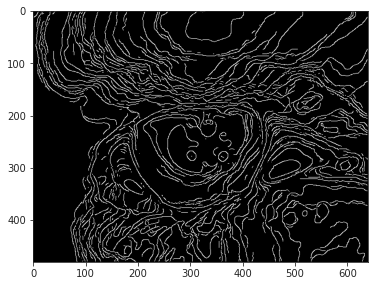

In [ ]:
# Load picture and detect edges
pupil = img_as_ubyte(flashes_removed_final.copy())

thresh_otsu = threshold_otsu(pupil)

#edges = canny(pupil, sigma=0.1, low_threshold=thresh_otsu*0.5, high_threshold=thresh_otsu)
edges = canny(pupil, sigma=1, low_threshold=1, high_threshold=10)

image_show(edges);

Aplicando a Transformada de Hough para detecção de círculos, de acordo com [tutorial](https://scikit-image.org/docs/dev/auto_examples/edges/plot_circular_elliptical_hough_transform.html).

In [ ]:
# Fornece uma gama de raios plausíveis
hough_radii = np.arange(40, 80, 2)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent circle
_, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

# Seleciona a região com maior raio encontrado
region = max(zip(cy, cx, radii), key=lambda item: item[2])
row_p, col_p, radius_p = region

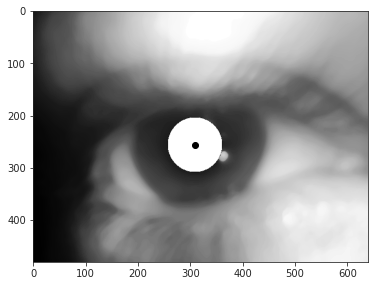

In [ ]:
r_coords_pupil, c_coords_pupil = circle(row_p, col_p, radius_p, shape=pupil.shape)
pupil[r_coords_pupil, c_coords_pupil] = 255

fig, ax = image_show(pupil)
ax.plot(col_p, row_p, 'ko');

Mostrando a posição da pupila.

In [ ]:
print('Pupila:', row_p, col_p, radius_p)

Pupila: 256 309 52


---

## Segmentação da Íris

Encontrando o valor no eixo Ox que define a transição da íris para a esclera.

In [ ]:
seg_iris = flashes_removed_final.copy()

edge_sobel = sobel(seg_iris)
edge_sobel_h = sobel_h(seg_iris)
edge_sobel_v = sobel_v(seg_iris)
edge_scharr = scharr(seg_iris)
edge_scharr_h = scharr_h(seg_iris)
edge_scharr_v = scharr_v(seg_iris)
edge_prewitt = prewitt(seg_iris)
edge_prewitt_h = prewitt_h(seg_iris)
edge_prewitt_v = prewitt_v(seg_iris)

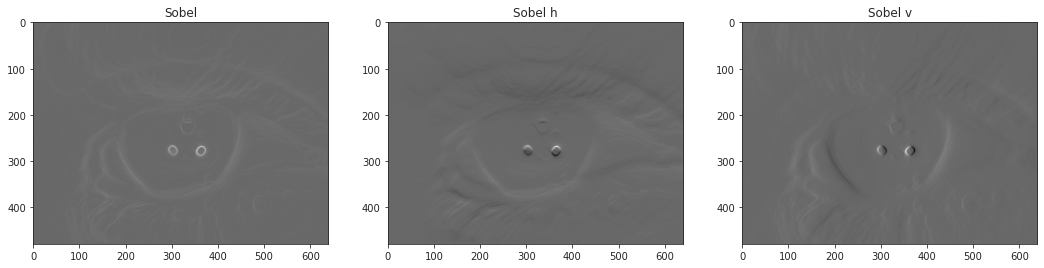

In [ ]:
image_show_all(edge_sobel, edge_sobel_h, edge_sobel_v, titles=['Sobel', 'Sobel h', 'Sobel v']);

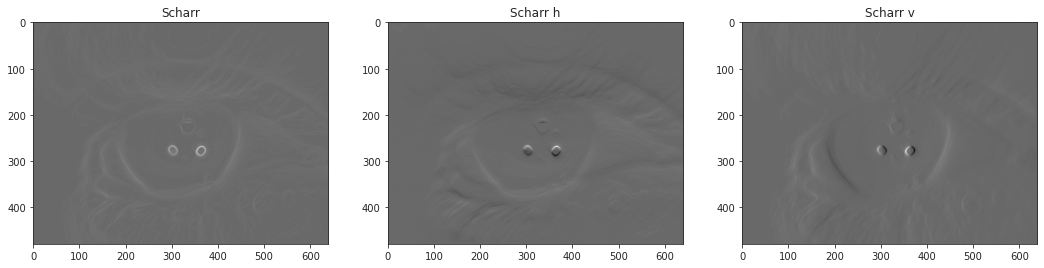

In [ ]:
image_show_all(edge_scharr, edge_scharr_h, edge_scharr_v, titles=['Scharr', 'Scharr h', 'Scharr v']);

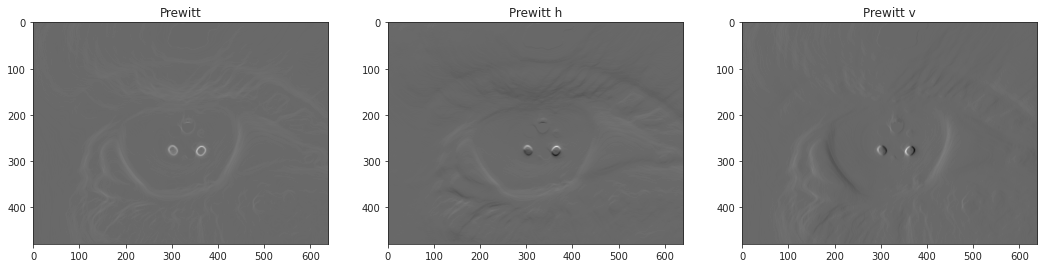

In [ ]:
image_show_all(edge_prewitt, edge_prewitt_h, edge_prewitt_v, titles=['Prewitt', 'Prewitt h', 'Prewitt v']);

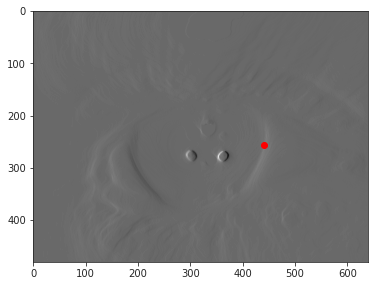

In [ ]:
seg_iris = edge_scharr_v.copy()
# seg_iris = edge_sobel_v.copy()

a = 20
b = 120
offset_col = col_p + radius_p + a

gradient_col = np.gradient(seg_iris[row_p, offset_col:offset_col+b])

col_edge = np.argmax(gradient_col) + offset_col

fig, ax = image_show(seg_iris)
ax.plot(col_edge, row_p, 'ro');

In [ ]:
iris = original.copy()

radius_i = col_edge - col_p
row_i = row_p
col_i = col_p

r_coords_iris, c_coords_iris = circle_perimeter(row_i, col_i, radius_i)
iris[r_coords_iris, c_coords_iris] = 1

Plotando a marcação da íris.

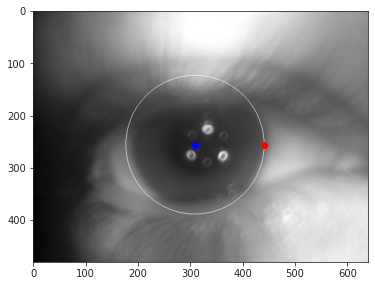

In [ ]:
fig, ax = image_show(iris)
ax.plot(col_i, row_i, 'bo');
ax.plot(col_edge, row_p, 'ro');

Mostrando a posição da íris.

In [ ]:
print('Íris:', row_i, col_i, radius_i)

Íris: 256 309 132


---

## Resultado Final

Pupila: 256 309 52
Íris: 256 309 132


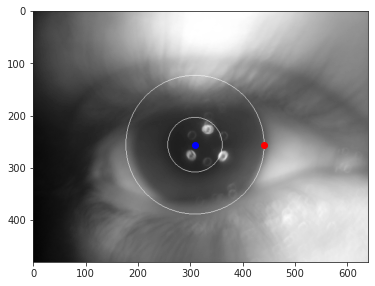

In [ ]:
segmented = original.copy()

segmented[r_coords_pupil, c_coords_pupil] = 1
segmented[r_coords_iris, c_coords_iris] = 1

fig, ax = image_show(segmented)
ax.plot(col_p, row_p, 'bo');
ax.plot(col_edge, row_p, 'ro');

print('Pupila:', row_p, col_p, radius_p)
print('Íris:', row_i, col_i, radius_i)